In [21]:
#compute the uDFT by noting DFT.DFT^* = D, a diagonal matrix, and factoring as D = RR^*, so uDFT = R^{-1}.DFT
#alternately, one could use unitary representations and normalization factors \sqrt{d_\rho/|G|}
#the resulting DFT will have signs \pm 1 on the diagonal DFT.DFT^* = S, which can be factored as s = rr^*, so S=RR^*
#again, uDFT = R^{-1}.DFT

In [1]:
from io_utils import load_csv_as_matrix, write_matrix_to_csv, save_array, load_array
from utils import conj_sqrt, discrete_log, brauer_map, round_complex
from plot_utils import plot_discrete_log, plot_arg_complex

In [37]:
#compute the uDFT by noting DFT.DFT^* = D, a diagonal matrix, and factoring as D = RR^*, so uDFT = R^{-1}.DFT
def unitary_dft(SGA):
    dft_matrix = SGA.dft()
    sign_diag = (dft_matrix*dft_matrix.H).diagonal()
    factor_diag_inv = diagonal_matrix([~conj_sqrt(d) for d in sign_diag])
    return factor_diag_inv*dft_matrix

In [38]:
#parameters and define the symmetric group algebra
n = 4; q = 7
F = GF(q**2)
SGA = SymmetricGroupAlgebra(F,n) # F[S_n], group algebra
assert F.characteristic() > 0, "F must have positive characteristic"
if not (F.is_field() and F.is_finite() and F.order().is_square()):
    raise ValueError("the base ring must be a finite field of square order")
if F.characteristic().divides(SGA.group().cardinality()):
    raise NotImplementedError("not implemented when p|n!; dimension of invariant forms may be greater than one")

In [39]:
#converting the unitary DFT over finite fields to a complex matrix using the root of unity map
U = unitary_dft(SGA)

In [40]:
#check that U is unitary over a finite field. .H is conjugate-transpose
U*U.H == 1

True

In [41]:
#compute the discrete log of each entry of U
dlog_U = U.apply_map(lambda x: discrete_log(F,x))

In [42]:
dlog_U

24 x 24 dense matrix over Integer Ring (use the '.str()' method to see the entries)

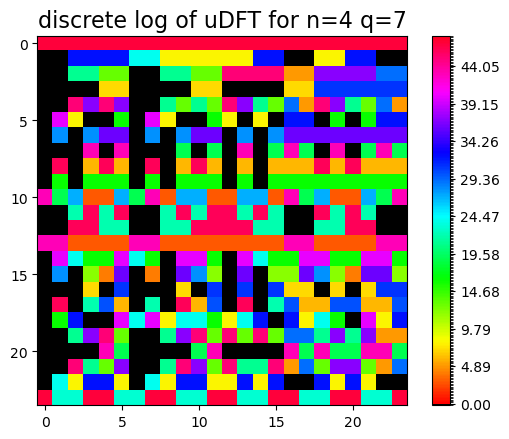

In [43]:
plot_discrete_log(F,dlog_U,path='plots/dft_matrix/',title=f"discrete log of uDFT for n={n} q={q}",normalize=None)

In [44]:
#complexify the uDFT matrix over F_q using the Brauer map
U_complex = matrix(CC,U.apply_map(lambda a: brauer_map(F,a)))

In [45]:
#compute the Gram matrix, taking inner products of rows and columns w.r.t conjugate inner product
#note: want this to be the identity matrix (so it would be unitary over \C), but currently it is not quite
gram = U_complex*U_complex.H

In [46]:
#round the (complex) Gram matrix to three decimal places
gram_rounded = gram.apply_map(lambda u:round_complex(u,3))

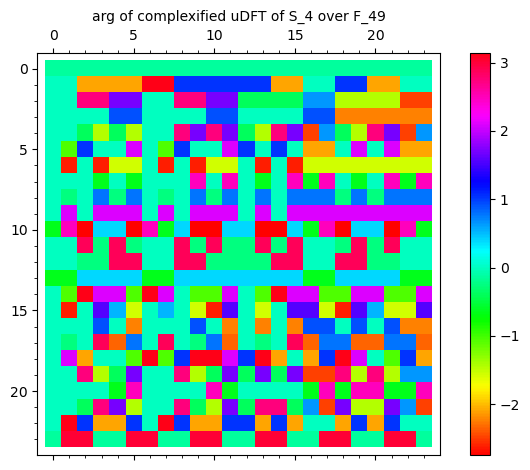

In [47]:
#plot the complexified version of the uDFT matrix over a finite field
plot_arg_complex(U_complex,title=f"arg of complexified uDFT of S_{n} over F_{q**2}")

In [48]:
#check that Gram matrix is conjugate symmetric (should be since it is U*U.H)
gram_rounded == gram_rounded.H

True

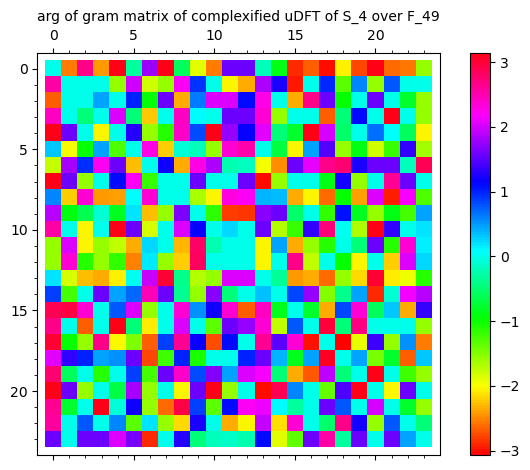

In [49]:
#plot the result of U_complex*U_complex.H to see how far it is from being unitary over the complex numbers
plot_arg_complex(gram_rounded, title=f"arg of gram matrix of complexified uDFT of S_{n} over F_{q**2}")

In [85]:
#load or compute+save the eigenvalues of the uDFT matrix over the algebraic closure of F
path = 'data/eigenvalues'
filename = f"eigenvalues_uDFT_n={n}_q={q}_deg=infty" + '.csv'
if os.path.exists(os.path.join(path, filename)):
    F_bar = F.algebraic_closure()
    eigenvalues_F_bar_list = load_array(path,filename)
    eigenvalues_F_bar = convert_str_repn_to_alg_closure(F_bar, eigenvalues_F_bar_list)
else:
    eigenvalues_F_bar = U.eigenvalues()
    save_array(eigenvalues_F_bar, path=path, filename=filename)

In [86]:
eigenvalues_F_bar

[6,
 5*z2 + 3,
 4*z14^13 + 6*z14^12 + 4*z14^11 + 5*z14^10 + 4*z14^8 + 3*z14^6 + 3*z14^5 + 5*z14^4 + z14^3 + 4*z14^2 + 4*z14 + 1,
 2*z14^13 + z14^12 + 2*z14^11 + 5*z14^10 + 6*z14^8 + 2*z14^7 + 6*z14^6 + 5*z14^5 + 4*z14^4 + 3*z14^3 + 3*z14^2 + 4*z14 + 2,
 z14^13 + 2*z14^12 + 2*z14^11 + 4*z14^10 + 4*z14^9 + 2*z14^6 + z14^3 + 2*z14 + 3,
 z14^13 + 4*z14^12 + 3*z14^11 + 5*z14^10 + z14^9 + 5*z14^6 + 4*z14^5 + 5*z14^4 + 5*z14^3 + z14^2 + 5*z14 + 3,
 3*z14^13 + 6*z14^12 + z14^11 + 3*z14^10 + 4*z14^9 + 6*z14^7 + 5*z14^6 + 3*z14^5 + 6*z14^4 + 2*z14^3 + 4*z14 + 5,
 2*z14^13 + 2*z14^12 + z14^11 + 3*z14^9 + 3*z14^8 + 3*z14^7 + 5*z14^5 + 4*z14^4 + 2*z14^3 + 4*z14^2 + 4*z14 + 6,
 6*z14^13 + 3*z14^12 + 6*z14^11 + 2*z14^9 + 4*z14^8 + 5*z14^6 + 4*z14^5 + z14^4 + 3*z14^3 + 3*z14^2,
 6*z30^29 + 3*z30^28 + 6*z30^27 + 2*z30^25 + 3*z30^24 + 3*z30^23 + 5*z30^22 + 3*z30^21 + 4*z30^20 + 4*z30^19 + 2*z30^17 + 6*z30^16 + 4*z30^15 + 6*z30^14 + 4*z30^12 + 3*z30^11 + 4*z30^10 + 6*z30^9 + 6*z30^8 + 5*z30^7 + 5*z30^6 +

In [36]:
#compute the maximum degree required for the eigenvalues
#this should agree with the splitting field degree, but sometimes it doesn't
max_deg_eigs = max([eig.minpoly().degree() for eig in eigenvalues_F_bar]); max_deg_eigs

NameError: name 'eigenvalues_F_bar' is not defined

In [97]:
#compute the multiplicity of each eigenvalue. check if all eigenvalues are distinct
from collections import Counter
multiplicities = Counter(eigenvalues_F_bar)
all_unique = all(count == 1 for count in multiplicities.values()); all_unique

True

In [98]:
#compute the charpoly of the uDFT matrix 
charpoly_F = U.charpoly(); print("charpoly_F: ",charpoly_F)

charpoly_F:  x^24 + z2*x^23 + (2*z2 + 2)*x^22 + (4*z2 + 4)*x^21 + (2*z2 + 6)*x^20 + 4*z2*x^19 + 2*z2*x^18 + (4*z2 + 3)*x^17 + (4*z2 + 6)*x^16 + (5*z2 + 2)*x^15 + 2*z2*x^14 + (6*z2 + 2)*x^13 + 5*z2*x^11 + (z2 + 5)*x^10 + (z2 + 1)*x^9 + z2*x^8 + (5*z2 + 5)*x^7 + (z2 + 5)*x^6 + (2*z2 + 3)*x^5 + 2*x^4 + (6*z2 + 1)*x^3 + (3*z2 + 4)*x^2 + (4*z2 + 6)*x + z2 + 3


In [99]:
#factor the characteristic polynomial over the base field GF(q**2) into irreducibles
charpoly_F_factor = charpoly_F.factor(); charpoly_F_factor

(x + 1) * (x + 2*z2 + 4) * (x^7 + (4*z2 + 4)*x^6 + (6*z2 + 5)*x^5 + 3*z2*x^4 + (4*z2 + 3)*x^3 + (z2 + 4)*x^2 + (3*z2 + 1)*x + 1) * (x^15 + (2*z2 + 5)*x^14 + (3*z2 + 2)*x^13 + (4*z2 + 4)*x^12 + 5*x^11 + (3*z2 + 5)*x^10 + (6*z2 + 2)*x^9 + (6*z2 + 2)*x^8 + (6*z2 + 2)*x^7 + (6*z2 + 2)*x^6 + (2*z2 + 6)*x^5 + (4*z2 + 1)*x^4 + z2*x^3 + (z2 + 4)*x^2 + (5*z2 + 2)*x + 5*z2 + 3)

In [80]:
#compute the degree, multiplicity of each irreducible factor of the charpoly over F
charpoly_F_deg_mult = [(poly[0].degree(), poly[1]) for poly in charpoly_F_factor]; charpoly_F_deg_mult

[(1, 1), (1, 1), (7, 1), (15, 1)]

In [81]:
#compute a splitting field of the characteristic polynomial
K = GF(q**max_deg_eigs); print(f"field containing all eigenvalues: K = {K}")
L = charpoly_F.splitting_field('a'); print(f"splitting field: L = {L}")
print("minpoly of K: ", K.multiplicative_generator().minimal_polynomial())

field containing all eigenvalues: K = Finite Field in z30 of size 7^30
splitting field: L = Finite Field in a of size 7^210
minpoly of K:  x^30 + x^22 + 4*x^21 + 4*x^20 + x^19 + 4*x^18 + x^16 + 2*x^15 + 3*x^14 + 6*x^13 + 5*x^12 + 2*x^11 + 3*x^10 + 3*x^9 + 2*x^8 + 4*x^7 + 2*x^6 + 3*x^5 + x^3 + 5*x^2 + 2*x + 3


In [29]:
#compute the charpoly of the uDFT matrix over K, L
charpoly_K = matrix(K,U).charpoly()
charpoly_L = matrix(L,U).charpoly()

KeyboardInterrupt: 

In [34]:
#load or compute+save eigenvalues over K
path = 'data/eigenvalues'
filename = f"eigenvalues_uDFT_n={n}_q={q}_deg={K.degree()}" + '.csv'
if os.path.exists(os.path.join(path, filename)):
    eigenvalues_list = load_array(path,filename)
    eigenvalues_K = [K(x) for x in eigenvalues_list]
else:
    eigenvalues_K = matrix(K,U).eigenvalues(extend=False)
    save_array(eigenvalues_K, path=path, filename=filename)

In [35]:
#load or compute+save the eigenvalues over L
path = 'data/eigenvalues'
filename = f"eigenvalues_uDFT_n={n}_q={q}_deg={L.degree()}" + '.csv'
if os.path.exists(os.path.join(path, filename)):
    eigenvalues_list = load_array(path,filename)
    eigenvalues_L = [L(x) for x in eigenvalues_list]
else:
    eigenvalues_L = matrix(L,U).eigenvalues(extend=False)
    save_array(eigenvalues_L, path=path, filename=filename)

In [36]:
#load or compute + save the discrete log (dlog) of the eigenvalues over K
path='data/discrete_log_eigenvalues'
filename=f"discrete_log_eigenvalues_uDFT_n={n}_q={q}_deg={K.degree()}" + '.csv'
if os.path.exists(os.path.join(path, filename)):
    dlog_eigenvalues_list = load_array(path,filename)
    dlog_eigenvalues_K = [int(x) for x in dlog_eigenvalues_list]
else:
    dlog_eigenvalues_K = list(map(lambda x: discrete_log(K,x), eigenvalues_K))
    save_array(log_eigenvalues_K, path=path, filename=filename)

In [37]:
#load or compute+save the discrete log (dlog) of the eigenvalues over L
path='data/discrete_log_eigenvalues'
filename=f"discrete_log_eigenvalues_uDFT_n={n}_q={q}_deg={L.degree()}" + '.csv'
if os.path.exists(os.path.join(path, filename)):
    dlog_eigenvalues_list = load_array(path,filename)
    dlog_eigenvalues_L = [int(x) for x in dlog_eigenvalues_list]
else:
    dlog_eigenvalues_L = list(map(lambda x: discrete_log(L,x), eigenvalues_K))
    save_array(log_eigenvalues_K, path=path, filename=filename)

In [38]:
#compute and save the complexified eigenvalue over K
#NOTE: use precomputed dlog values for the Brauer map to avoid recomputing them
path='data/complexified_eigenvalues'
filename=f"complexified_eigenvalues_uDFT_n={n}_q={q}_deg={K.degree()}" + '.csv'
complexified_eigenvalues_K = [brauer_map(K,log_a=log_eig) for log_eig in dlog_eigenvalues_K]
save_array(complexified_eigenvalues_K, path=path, filename=filename)

In [39]:
#compute and save the complexified eigenvalues over L
#NOTE: use precomputed dlog values for the Brauer map to avoid recomputing them
path='data/complexified_eigenvalues'
filename=f"complexified_eigenvalues_uDFT_n={n}_q={q}_deg={L.degree()}" + '.csv'
complexified_eigenvalues_L = [brauer_map(L,log_a=log_eig) for log_eig in dlog_eigenvalues_L]
save_array(complexified_eigenvalues_L, path=path, filename=filename)

In [88]:
"""
TO-DO: compute Galois orbits of eigenvalues (roots of charpoly over splitting field)
NOTE: 
    - if K = splitting field, F = GF(q**2)
    - Gal(K/F) is relative Galois group, and F fixes coefficients of charpoly
    - size of orbits should divide |Gal(K/F)| and add up to n
    - if K = GF(q**m), then |Gal(K/F)| = m/2
    - for n=4, q=7: K = GF(7**30), L = GF(7**210). so m=30 or m=210, therefore 
    - looks like charpoly is degree 24, and factoring over F into irreducibles of degree 1+1+7+15
    - this suggest we really need to be working over the splitting field L = GF(q**210) since `7|105` but `7 \nmid 15`
    - over L, the sizes of Galois orbits are {1,15}
    - over L, the sizes of Galois orbits are {1,7,15}
    - the equivalence classes over L capture all possible Galois orbits (including of size 7)
    - we need to work over the splitting field, even though the degree is large
""";

In [41]:
#define the q^th power map, which is the r^th power of the Frobenius map if q=p^r
alpha = lambda x: x**(q**2)

In [42]:
#compute the Galois orbit of an element `x` of a finite field `GF(q)`
def galois_orbit(alpha,x):
    orbit = [x]
    while alpha(orbit[-1]) != orbit[0]:
        orbit.append(alpha(orbit[-1]))
    return orbit

In [161]:
#compute Galois orbit sizes for each eigenvalue in K
galois_orbit_size_K = [len(galois_orbit(alpha,eig)) for eig in eigenvalues_K]; print(galois_orbit_size_K)

[1, 15, 15, 15, 15, 1, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]


In [162]:
#compute Galois orbit sizes for each eigenvalue in L
galois_orbit_size_L = [len(galois_orbit(alpha,eig)) for eig in eigenvalues_L]; print(galois_orbit_size_L)

[1, 7, 15, 15, 15, 15, 15, 15, 1, 15, 15, 15, 7, 15, 15, 7, 15, 15, 7, 7, 7, 15, 7, 15]


In [49]:
"""
 - break apart the list elements of finite field elements into Galois orbit equivalence classes
"""
def galois_orbit_equiv_classes(alpha, elements):
    orbits = {}
    seen = set()
    class_counter = 0
    
    for x in elements:
        if x not in seen:
            orbit = [x]
            seen.add(x)
            while True:
                next_element = alpha(orbit[-1])
                if next_element == orbit[0]:
                    break
                orbit.append(next_element)
                seen.add(next_element)
            
            orbits[f'orbit_{class_counter}'] = orbit
            class_counter += 1
    
    return orbits

In [71]:
#compute the equivalence classes of orbits under the Galois action on eigenvalues over K, which is not the splitting field
galois_orbit_classes_K = galois_orbit_equiv_classes(alpha,eigenvalues_K)
#compute size of Galois orbit classes for eigenvalues_K
galois_orbit_class_sizes_K = [len(galois_orbit_classes[key]) for key in galois_orbit_classes_K]; print(galois_orbit_class_sizes_K)

[1, 15, 1]


In [72]:
#compute the equivalence classes of orbits under the Galois action on eigenvalues over L, the splitting field
galois_orbit_classes_L = galois_orbit_equiv_classes(alpha,eigenvalues_L)
#compute size of Galois orbit classes for eigenvalues_L
galois_orbit_class_sizes_L = [len(galois_orbit_classes_L[key]) for key in galois_orbit_classes_L]; print(galois_orbit_class_sizes_L)

[1, 7, 15, 1]


In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Extract real and imaginary parts for plotting
real_parts = [eig.real() for eig in complexified_eigenvalues_K]
imaginary_parts = [eig.imag() for eig in complexified_eigenvalues_K]

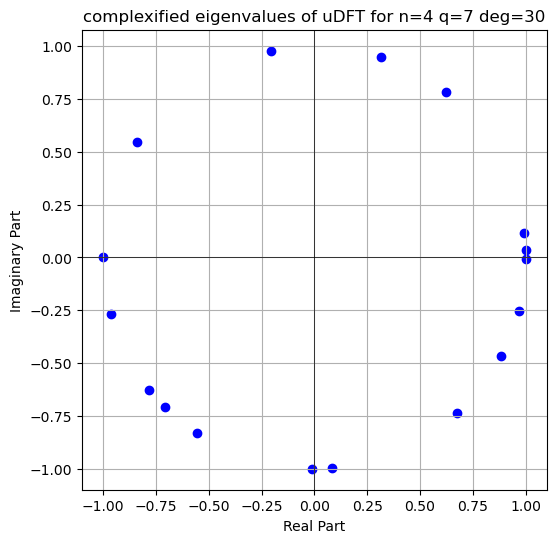

In [63]:
# Plotting the eigenvalues on the complex plane
title = f"complexified eigenvalues of uDFT for n={n} q={q} deg={K.degree()}"
plt.figure(figsize=(6,6))
plt.scatter(real_parts, imaginary_parts, color='blue', label="Eigenvalues")
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(title)
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid(True)
plt.savefig('plots/eigenvalues/finite_fields/' + title.replace(' ','_') + '.png', dpi=300, bbox_inches="tight")
plt.show()

In [38]:
#compute the eigenvectors over a splitting field
D, P = matrix(L,U).eigenmatrix_right()

In [40]:
write_matrix_to_csv(P,filename=f"data/eigenvectors/eigenvectors_unitary_dft_symmetric_group_finite_field_n={n}_q={q}.csv")

In [77]:
#take the discrete log of the eigenvector matrix
path = 'data/discrete_log_eigenvector_matrix'
filename = f"discrete_log_dft_symmetric_group_finite_field_eigenvector_matrix_n={n}_q={q}.csv"
full_path = os.path.join(path, filename)
if os.path.exists(full_path):
    dlog_P = load_csv_as_matrix(full_path)
else:
    dlog_P = P.apply_map(lambda x: discrete_log(L,x)); dlog_P

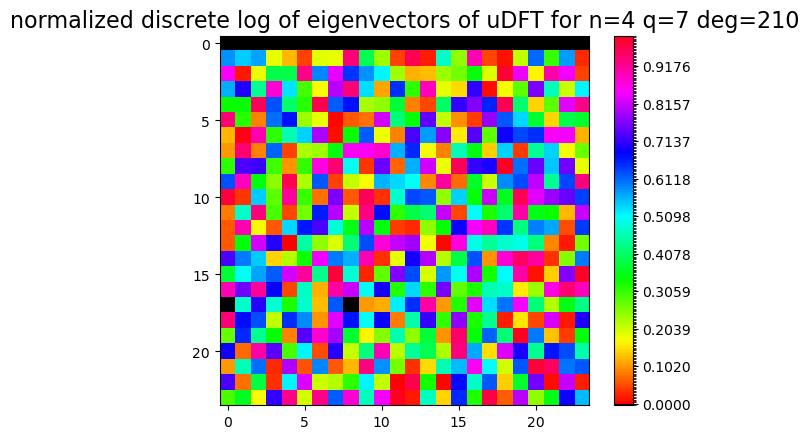

In [87]:
#plot the discrete log of the eigenvector matrix P
#NOTE: the `normalize` parameter is required for n=4 or above
plot_discrete_log(L,dlog_P,path='plots/eigenvectors/',title=f"normalized discrete log of eigenvectors of uDFT for n={n} q={q} deg={L.degree()}",normalize="rescale")

In [79]:
def dump_discrete_log(L, P, path, filename):
    """
    - compute the discrete log of each entry of P, the eigenvector matrix of the uDFT of S_n over F_{q^2}
    - write the resulting matrix to a comma separated value file
    - include a progress bar since computing discrete logs for large fields takes a long time
    """
    total = P.nrows() * P.ncols()
    count = 0
    full_path = os.join(path,filename)
    with open(full_path, "w") as f:
        for i in range(P.nrows()):
            for j in range(P.ncols()):
                log_value = discrete_log(L, P[i, j])
                f.write(str(log_value))
                if j != P.ncols()-1:
                    f.write(",")
                count += 1
                # Print progress as a percentage
                progress = float(count) / total * 100
                print(f"Progress: {progress:.2f}%\n", end="\r", flush=True)
            f.write("\n")
    return "done"

In [40]:
path = "data/eigenvectors"
filename = f"discrete_log_dft_symmetric_group_finite_field_eigenvector_matrix_n={n}_q={q}.csv"
dump_discrete_log(L, P, path=path, filename=filename)

Progress: 0.17%
Progress: 0.35%
Progress: 0.52%
Progress: 0.69%
Progress: 0.87%
Progress: 1.04%
Progress: 1.22%
Progress: 1.39%
Progress: 1.56%
Progress: 1.74%
Progress: 1.91%
Progress: 2.08%
Progress: 2.26%
Progress: 2.43%
Progress: 2.60%
Progress: 2.78%
Progress: 2.95%
Progress: 3.12%
Progress: 3.30%
Progress: 3.47%
Progress: 3.65%
Progress: 3.82%
Progress: 3.99%
Progress: 4.17%
Progress: 4.34%
Progress: 4.51%
Progress: 4.69%
Progress: 4.86%
Progress: 5.03%
Progress: 5.21%
Progress: 5.38%
Progress: 5.56%
Progress: 5.73%
Progress: 5.90%
Progress: 6.08%
Progress: 6.25%
Progress: 6.42%
Progress: 6.60%
Progress: 6.77%
Progress: 6.94%
Progress: 7.12%
Progress: 7.29%
Progress: 7.47%
Progress: 7.64%
Progress: 7.81%
Progress: 7.99%
Progress: 8.16%
Progress: 8.33%
Progress: 8.51%
Progress: 8.68%
Progress: 8.85%
Progress: 9.03%
Progress: 9.20%
Progress: 9.38%
Progress: 9.55%
Progress: 9.72%
Progress: 9.90%
Progress: 10.07%
Progress: 10.24%
Progress: 10.42%
Progress: 10.59%
Progress: 10.76%
Pro

'done'